# Projet 7 : Implémentez un modèle de scoring : Random Forest

L'objectif de ce notebook est l'utilisation de Random Forest pour voir son efficacité sur la classification des clients éligibles ou non à un crédit.

La méthode [Random Forest](https://www.journaldunet.fr/web-tech/guide-de-l-intelligence-artificielle/1501905-random-forest-ou-foret-aleatoire/)
est composée de plusieurs arbres de décision, entrainés de manière indépendante sur des sous-ensembles du data set d'apprentissage (méthode de bagging). Chacun produit une estimation, et c'est la combinaison des résultats qui va donner la prédiction finale qui se traduit par une variance réduite. 


## Importation des modules

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.3 MB/s 


In [ ]:
import numpy as np 
import pandas as pd

## PLOT
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier


## Scores
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_recall_fscore_support
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  make_scorer

## feature importance
import shap

## Threshold
from yellowbrick.classifier.threshold import discrimination_threshold

## Export
import pickle

## Warning
import warnings

In [ ]:
warnings.filterwarnings("ignore")

##  Importation de données

In [ ]:
use_colab = True 

if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    PATH ='/content/drive/MyDrive/'
else:
    PATH ='/data/'

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv(PATH + 'df_final.csv')

In [ ]:
X_train_smtomek = pd.read_csv(PATH+"X_train_smtomek.csv")
y_train_smtomek = pd.read_csv(PATH+"y_train_smtomek.csv")

In [ ]:
X_test_smtomek =  pd.read_csv(PATH+"X_test_smtomek.csv")
y_test_smtomek = pd.read_csv(PATH+"y_test_smtomek.csv")

Les paramètres de notre modèle à optimiser sont :

- (n_estimators) Le nombre d'arbres  
- (max_depth) La profondeur maximale de l'arbre 
- (criterions) La fonction pour mesurer la qualité d'un split. « gini » pour l'impureté de Gini et « entropie » pour le gain d'informations. 

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

model_LR= RandomForestClassifier(random_state=0).fit(X_train_smtomek,y_train_smtomek)

In [ ]:
model_LR.fit(X_train_smtomek,y_train_smtomek)

RandomForestClassifier(random_state=0)

In [ ]:
print(f'Accuracy: {accuracy_score(y_train_smtomek, model_LR.predict(X_train_smtomek))}')
print(f'Precision: {precision_score(y_train_smtomek, model_LR.predict(X_train_smtomek))}')
print(f'Recall: {recall_score(y_train_smtomek, model_LR.predict(X_train_smtomek))}')

Accuracy: 0.9999940427610611
Precision: 1.0
Recall: 0.9999882048348382


In [ ]:
y_prob = model_LR.predict_proba(X_test_smtomek)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model_LR.score(X_test_smtomek, y_pred)

1.0

In [ ]:
confusion_matrix=metrics.confusion_matrix(y_test_smtomek,y_pred)
confusion_matrix

array([[113085,     40],
       [  9857,     23]])

In [ ]:
auc_roc=metrics.roc_auc_score(y_test_smtomek,y_pred)
auc_roc

0.5009871720312256

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_smtomek, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6824140291229562

Text(0.5, 0, 'False Positive Rate')

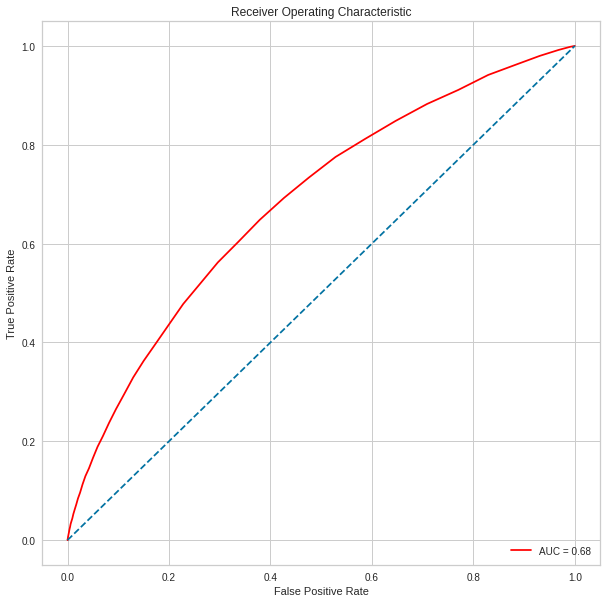

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Optimisation et meilleurs hyperparamètres

In [ ]:
# We will first use RandomizedSearchCV to narrow down the sample space for GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [i for i in range(10,20,10)]
max_depth = [i for i in range(10,20,10)]
max_depth.append(None)
max_features = ['auto','sqrt']

random_grid = {'n_estimators' : n_estimators,
               'max_depth' : max_depth,
               'max_features' : max_features}

rf_new = RandomForestClassifier(random_state=0)
rf_rand = RandomizedSearchCV(rf_new,random_grid,n_iter=10,cv=10,verbose=0,random_state=0,n_jobs=-1)
rf_rand.fit(X_train_smtomek,y_train_smtomek)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [10]},
                   random_state=0)

In [ ]:
rf = model_LR

In [ ]:
print ('Best params obtained via random search : ',rf_rand.best_params_)
print ('AUC achieved using the base model : ',round(roc_auc_score(y_test_smtomek,rf.predict_proba(X_test_smtomek)[:,1]),3))
best_rand = rf_rand.best_estimator_
print ('AUC achieved using the best params achieved in Randomized search : ',round(roc_auc_score(y_test_smtomek,best_rand.predict_proba(X_test_smtomek)[:,1]),3))

Best params obtained via random search :  {'n_estimators': 10, 'max_features': 'auto', 'max_depth': None}
AUC achieved using the base model :  0.682
AUC achieved using the best params achieved in Randomized search :  0.614


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators' : [10,20,30],
              'max_depth' : [10,20,30,None],
              'max_features' : ['auto','sqrt']}

rf_new = RandomForestClassifier(random_state = 0)
rf_grid = GridSearchCV(rf_new,param_grid,verbose=0,n_jobs=-1,cv=10)
rf_grid.fit(X_train_smtomek,y_train_smtomek)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [10, 20, 30]})

In [ ]:
print ('Best params achieved via GridSearch : ',rf_grid.best_params_)
rf_best = rf_grid.best_estimator_
print ('Best AUC achieved using best params : ',round(roc_auc_score(y_test_smtomek,rf_best.predict_proba(X_test_smtomek)[:,1]),3))

On en conclut ici que Random Forest peut nous servir en tant que modèle car il est performant